In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import json
import glob
import scipy
import scipy.signal as signal
from matplotlib.dates import date2num


## Fitbit data preperation

In [2]:
Fitbit_dir = "./Fitbit/ShiYangLee/Physical Activity/heart_rate-2022-03-29.json"

In [3]:
# Importing fitbit's heart rate data on day of interest
df_fitbit = pd.read_json(Fitbit_dir)
df_fitbit.head()

,dateTime,value
0,2022-03-28 23:00:06,"{'bpm': 56, 'confidence': 3}"
1,2022-03-28 23:00:21,"{'bpm': 56, 'confidence': 3}"
2,2022-03-28 23:00:31,"{'bpm': 57, 'confidence': 3}"
3,2022-03-28 23:00:41,"{'bpm': 58, 'confidence': 3}"
4,2022-03-28 23:00:46,"{'bpm': 57, 'confidence': 3}"


In [4]:
# Check for missing values
df_fitbit.isnull().sum()

dateTime    0
value       0
dtype: int64

In [5]:
# Since raw fitbit data is not in the desired form, we need to write a function 
# to split the data.
def data_split(data):
    if 'value' not in data.columns:
        print("The dataframe is already splitted!")
        return data
    data['value'] = data['value'].astype('str')
    tmp = data.value.str.split(' ', expand = True)
    data[['bpm', 'confidence']] = tmp[[1, 3]]
    strip_col = ['bpm', 'confidence']
    data[strip_col] = data[strip_col].apply(lambda x: x.str.strip(",} "))
    data.drop("value", axis = 1, inplace = True)

In [6]:
data_split(df_fitbit)

In [7]:
# The data also require further cleaning
def fitbit_dataprep(df_fitbit):
    """
    A function for cleaning fitbit data, converting bpm from string to int.
    Also setting dateTime data to indexes with straightforward format.
    """
    if df_fitbit.index.dtype == pd.api.types.is_datetime64_any_dtype:
        print("The dataframe was already prepared!")
        return df_fitbit
    df_fitbit = df_fitbit.set_index('dateTime')
    df_fitbit['bpm'] = df_fitbit['bpm'].astype('int')
    df_fitbit['confidence'] = df_fitbit['confidence'].astype('int')
    df_fitbit.index = pd.to_datetime(df_fitbit.index, format = '%Y-%m-%d %H:%M:%S')
    return df_fitbit

In [8]:
df_fitbit = fitbit_dataprep(df_fitbit)

In [9]:
# Shifting data to account for british summer time change
# (Do your own job, Fitbit!)
df_fitbit.index = df_fitbit.index.shift(1, freq='H')

As the aim of the notebook is to compare Fitbit towards Garmin's data, which the heart rate data is by the minutes, we are going to trim Fitbit's data down and to match Garmin's dateTime.

In [10]:
# Preparing dummy indeces.
tmp = pd.date_range('2022-03-29 00:00', '2022-3-30 00:00', freq = 'T')
print(tmp)
print(len(tmp))

DatetimeIndex(['2022-03-29 00:00:00', '2022-03-29 00:01:00',
               '2022-03-29 00:02:00', '2022-03-29 00:03:00',
               '2022-03-29 00:04:00', '2022-03-29 00:05:00',
               '2022-03-29 00:06:00', '2022-03-29 00:07:00',
               '2022-03-29 00:08:00', '2022-03-29 00:09:00',
               ...
               '2022-03-29 23:51:00', '2022-03-29 23:52:00',
               '2022-03-29 23:53:00', '2022-03-29 23:54:00',
               '2022-03-29 23:55:00', '2022-03-29 23:56:00',
               '2022-03-29 23:57:00', '2022-03-29 23:58:00',
               '2022-03-29 23:59:00', '2022-03-30 00:00:00'],
              dtype='datetime64[ns]', length=1441, freq='T')
1441


In [11]:
# Get nearest datapoint in Fitbit df to the dummy indices.
loc = [df_fitbit.index.get_loc(x, "nearest") for x in tmp]

# Trim Fitbit df to the required rows.
df_fitbit = df_fitbit.iloc[loc]

# Setting the indices to correct time.
df_fitbit.index = df_fitbit.index.round(freq = "T")
df_fitbit.head()

,bpm,confidence
dateTime,,
2022-03-29 00:00:00,56,3
2022-03-29 00:01:00,58,3
2022-03-29 00:02:00,56,3
2022-03-29 00:03:00,56,3
2022-03-29 00:04:00,55,3


Now that the Fitbit data looks good, it's time to shift focus to Garmin data.

## Garmin data preperation.

The garmin data was acquired through scripts named GarminDB, which utilized the API for Garmin Connect. The API convert unreadable raw FIT files to healthier databases. Let's look at what databases there are.

In [12]:
!ls ./HealthData/DBs

fitbit.db	      garmin.db		    garmin_summary.db  summary.db
garmin_activities.db  garmin_monitoring.db  mshealth.db


In [13]:
# Exploring what are contained in the garmin.db.
garmin_db = "./HealthData/DBs/garmin.db"
con = sqlite3.connect(garmin_db)
cur = con.cursor()
table = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", con)
table

,name
0,_attributes
1,attributes
2,devices
3,weight
4,stress
5,sleep
6,sleep_events
7,resting_hr
8,daily_summary
9,files


In [14]:
garmin_df = pd.read_sql_query("SELECT * FROM sleep", con)
garmin_df.head()

,day,start,end,total_sleep,deep_sleep,light_sleep,rem_sleep,awake
0,2020-08-23,None,None,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000
1,2020-10-02,None,None,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000
2,2021-11-08,None,None,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000
3,2020-01-31,None,None,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000
4,2019-03-15,None,None,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000


Not what we are workign for. Further digging reveals that full raw data are located in "monitoring" databases.

In [15]:
garmin_monit_db = "./HealthData/DBs/garmin_monitoring.db"
garmin_monit_con = sqlite3.connect(garmin_monit_db)
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", garmin_monit_con)

,name
0,_attributes
1,monitoring_info
2,monitoring_hr
3,monitoring_intensity
4,monitoring_climb
5,monitoring
6,monitoring_rr
7,monitoring_pulse_ox


In [16]:
garmin_hr = pd.read_sql_query("SELECT * FROM monitoring_hr", garmin_monit_con)
garmin_hr.describe()

,heart_rate
count,32360.000000
mean,73.341718
std,17.253314
min,44.000000
25%,58.000000
50%,73.000000
75%,84.000000
max,171.000000


In [17]:
# Only select the particular day of March 29 2022.
garmin_0329_hr = garmin_hr.loc[(garmin_hr['timestamp'] >= '2022-03-29') & \
                               (garmin_hr['timestamp'] < '2022-03-30')]
print(garmin_0329_hr)

                        timestamp  heart_rate
2327   2022-03-29 09:29:00.000000         117
2328   2022-03-29 09:30:00.000000         123
2329   2022-03-29 09:31:00.000000         110
2330   2022-03-29 09:32:00.000000          97
2331   2022-03-29 09:33:00.000000          92
...                           ...         ...
13375  2022-03-29 23:56:00.000000          55
13376  2022-03-29 23:57:00.000000          56
13377  2022-03-29 23:58:00.000000          57
13378  2022-03-29 23:59:00.000000          56
13379  2022-03-29 23:59:59.000000          58

[1036 rows x 2 columns]


In [18]:
# Defines function for data preperation for Garmin data.

# For filling null values of heart rate data, we have chosed the method 
# of taking the average of values before and after the null windows.
def average_fill(data):
    """
    Function defined for filling null values in a time series panda series.
    The method is by adding forward filling and backward filling in to 
    the original data, and taking averages, dividing by 2.
    
    Any null window will be filled by the average of values before and after
    the window.
    """
    return data.ffill().fillna(method = 'bfill').\
                    add(data.bfill().fillna(method = 'ffill')).div(2)

def garmin_prep(data, start = None, end = None, reindex = 'T', \
               data_type = 'monit'):
    """
    Function for garmin data preperation, setting timetamp as indices,
    converting datetime to format from years to seconds. Also fill null
    values with average filling method.
    """
    if data.index.dtype == pd.api.types.is_datetime64_any_dtype:
        print("The datafarme had already been prepared!")
        return None
    if start != None and end != None:
        data = data.loc[(data['timestamp'] >= start) & (data['timestamp'] < end)]
    data_tmp = data.set_index('timestamp')
    data_tmp.index = pd.to_datetime(data_tmp.index, format="%Y-%m-%d %H:%M:%S")
    if reindex != False:
        data_tmp = data_tmp.reindex(pd.date_range(start, end, freq = reindex))
    if data_type == 'monit':
        data_tmp = average_fill(data_tmp)
        assert data_tmp.isnull().sum().values == 0
    elif data_type == 'act_monit':
        data_tmp['hr'] = average_fill(data_tmp['hr'])
        print(data_tmp['hr'].isnull().sum())
        assert data_tmp['hr'].isnull().sum() == 0
    return data_tmp

In [19]:
print(pd.date_range('2022-03-29 00:00', '2022-03-30 00:00', freq = 'T'))

DatetimeIndex(['2022-03-29 00:00:00', '2022-03-29 00:01:00',
               '2022-03-29 00:02:00', '2022-03-29 00:03:00',
               '2022-03-29 00:04:00', '2022-03-29 00:05:00',
               '2022-03-29 00:06:00', '2022-03-29 00:07:00',
               '2022-03-29 00:08:00', '2022-03-29 00:09:00',
               ...
               '2022-03-29 23:51:00', '2022-03-29 23:52:00',
               '2022-03-29 23:53:00', '2022-03-29 23:54:00',
               '2022-03-29 23:55:00', '2022-03-29 23:56:00',
               '2022-03-29 23:57:00', '2022-03-29 23:58:00',
               '2022-03-29 23:59:00', '2022-03-30 00:00:00'],
              dtype='datetime64[ns]', length=1441, freq='T')


In [20]:
garmin_0329_hr = garmin_prep(garmin_hr, '2022-03-29 00:00', '2022-03-30 00:00')
print(garmin_0329_hr.head())

                     heart_rate
2022-03-29 00:00:00        55.0
2022-03-29 00:01:00        55.0
2022-03-29 00:02:00        55.0
2022-03-29 00:03:00        55.0
2022-03-29 00:04:00        56.0


In [21]:
def garmin_vs_fitbit(fit, gar, gar_act = False):
    gar_col = 'hr' if gar_act else 'heart_rate'
    gar.plot(y = gar_col, use_index=True,  kind = 'line', \
                    figsize = (12,12), label = 'Garmin', grid = True, ylabel = 'Heart Rate')
    fit['bpm'].plot(y = 'bpm', grid = True, kind = 'line', linewidth = 1 \
                      ,  label = 'Fitbit', legend = True)
    

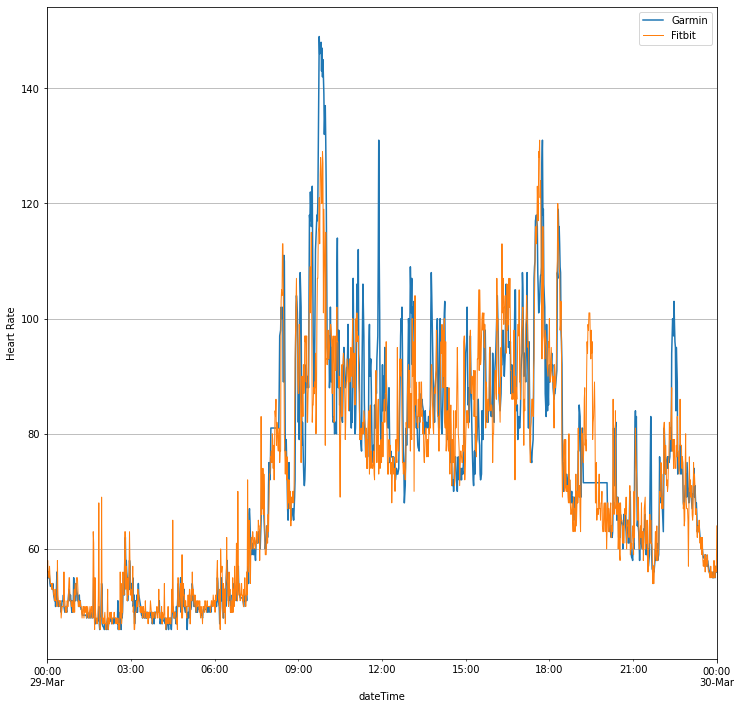

In [22]:
garmin_vs_fitbit(df_fitbit, garmin_0329_hr)

As seen in the plot above, Garmin has a tendency of overestimating hr (up to 20 bpm) when there are spikes. This result is consistent with my experiences in hand measuring my own hr. There is suggestion that Garmin's hr algorithm is loosely tied with number of steps. Further data collection and investigation are required to check the claim.

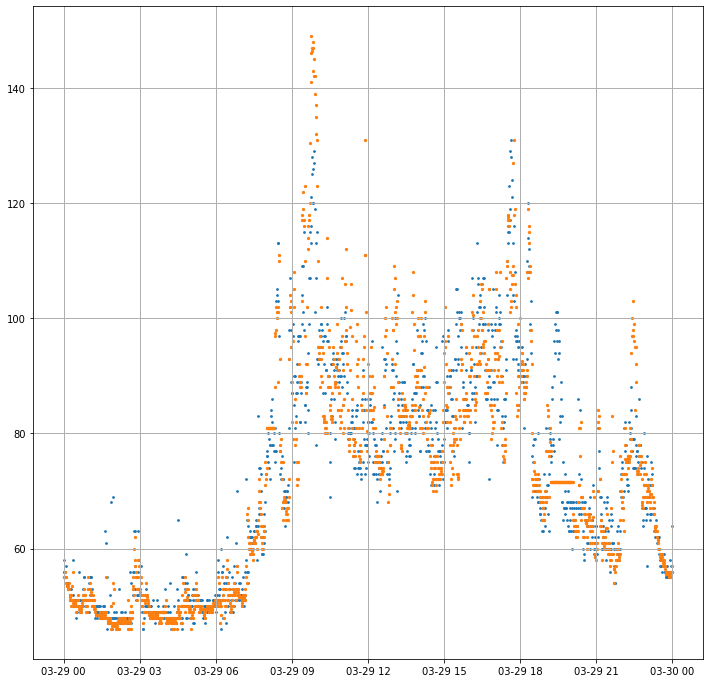

In [23]:
plt.rcParams["figure.figsize"] = (12,12)
plt.scatter(df_fitbit.index, y = 'bpm', s=3,  data = df_fitbit )
plt.scatter(garmin_0329_hr.index, y = 'heart_rate', s=5,  data = garmin_0329_hr )
plt.grid(linestyle='-', linewidth=1)

In [24]:
df_fitbit['bpm']

dateTime
2022-03-29 00:00:00    56
2022-03-29 00:01:00    58
2022-03-29 00:02:00    56
2022-03-29 00:03:00    56
2022-03-29 00:04:00    55
                       ..
2022-03-29 23:56:00    55
2022-03-29 23:57:00    57
2022-03-29 23:58:00    56
2022-03-29 23:59:00    56
2022-03-30 00:00:00    64
Name: bpm, Length: 1441, dtype: int64

Now let's investigate in the correlation between Fitbit and Garmin.

In [25]:
corr_df = df_fitbit.merge(garmin_0329_hr, left_index = True, right_index = True)
corr_df

,bpm,confidence,heart_rate
2022-03-29 00:00:00,56,3,55.0
2022-03-29 00:01:00,58,3,55.0
2022-03-29 00:02:00,56,3,55.0
2022-03-29 00:03:00,56,3,55.0
2022-03-29 00:04:00,55,3,56.0
...,...,...,...
2022-03-29 23:56:00,55,3,55.0
2022-03-29 23:57:00,57,3,56.0
2022-03-29 23:58:00,56,3,57.0
2022-03-29 23:59:00,56,3,56.0


In [26]:
def corr_plot(data, save = False):
    plt.rcParams["figure.figsize"] = (8,8)
    plt.figure()
    plt.scatter(corr_df['bpm'], corr_df['heart_rate'], s = 5)
    x = list(range(int(min(list(data['bpm']) + list(data['heart_rate']))), \
                  int(max(list(data['bpm']) + list(data['heart_rate'])))))
    y = x
    plt.plot(x, y)
    tittle = "Heart rate comparison between Garmin and Fitbit"
    plt.title(tittle)
    plt.xlabel("Fitbit hr")
    plt.ylabel('Garmin hr')
    if save == True:
        plt.savefig(f"{tittle}")
    plt.show()

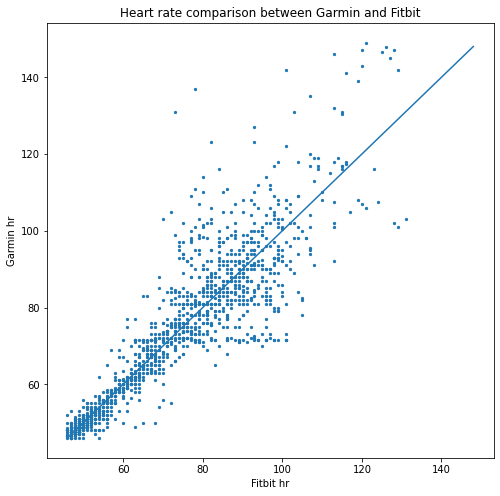

In [27]:
corr_plot(corr_df, save = True)

/home/shiya/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bpm', ylabel='heart_rate'>

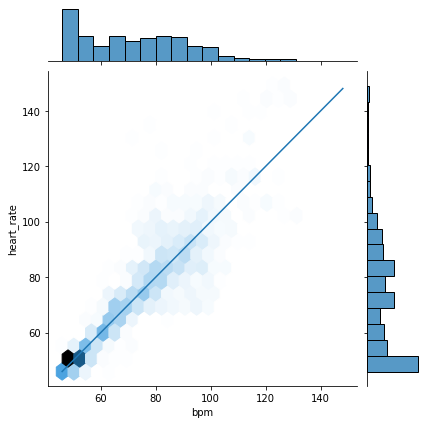

In [28]:
joint_kws=dict(gridsize=20)
sns.jointplot(data = corr_df[~corr_df.index.duplicated()] , x="bpm", \
              y="heart_rate", kind = 'hex', joint_kws = joint_kws, palette = sns.dark_palette("seagreen", as_cmap=True))
x = list(range(int(min(list(corr_df['bpm']) + list(corr_df['heart_rate']))), \
                  int(max(list(corr_df['bpm']) + list(corr_df['heart_rate'])))))
y = x
sns.lineplot(x, y)

In [29]:
corr_df['bpm']

2022-03-29 00:00:00    56
2022-03-29 00:01:00    58
2022-03-29 00:02:00    56
2022-03-29 00:03:00    56
2022-03-29 00:04:00    55
                       ..
2022-03-29 23:56:00    55
2022-03-29 23:57:00    57
2022-03-29 23:58:00    56
2022-03-29 23:59:00    56
2022-03-30 00:00:00    64
Name: bpm, Length: 1441, dtype: int64

In [30]:
corr_df.loc[corr_df.index.duplicated()]

,bpm,confidence,heart_rate
2022-03-29 04:17:00,48,3,47.0
2022-03-29 10:23:00,99,1,107.0


In [31]:
corr_df.loc['2022-03-29 04:17:00']

,bpm,confidence,heart_rate
2022-03-29 04:17:00,48,3,47.0
2022-03-29 04:17:00,48,3,47.0


In [32]:
act_dir = './Fitbit/ShiYangLee/Physical Activity/exercise-0.json'
pd.set_option('display.max_columns', None)
act_df = pd.read_json(act_dir)
act_df.head(2)

,logId,activityName,activityTypeId,activityLevel,averageHeartRate,calories,duration,activeDuration,steps,source,logType,manualValuesSpecified,heartRateZones,lastModified,startTime,originalStartTime,originalDuration,hasGps,shouldFetchDetails,hasActiveZoneMinutes,distance,distanceUnit,tcxLink,speed,pace,elevationGain,activeZoneMinutes,vo2Max
0,46265675913,Fitstar: Personal Trainer,3104,"[{'minutes': 0, 'name': 'sedentary'}, {'minute...",95,77,1146000,1146000,159.0,"{'type': 'app', 'name': 'Fitbit for Android', ...",manual,"{'calories': False, 'distance': True, 'steps':...","[{'name': 'Out of Range', 'min': 30, 'max': 98...",02/27/22 09:27:55,02/27/22 09:08:19,02/27/22 09:08:19,1146000,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,46265383938,Yoga,52000,"[{'minutes': 0, 'name': 'sedentary'}, {'minute...",100,86,1273000,1273000,32.0,"{'type': 'app', 'name': 'Fitbit for Android', ...",manual,"{'calories': False, 'distance': True, 'steps':...","[{'name': 'Out of Range', 'min': 30, 'max': 98...",02/27/22 22:05:19,02/27/22 21:43:36,02/27/22 21:43:36,1273000,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
act_df = act_df[(act_df['activityName'] == 'Run') & (act_df['originalStartTime'] >= '03/23/22')]
longest_run_df = act_df.loc[act_df['distance'].idxmax()]
longest_run_df

logId                                                          46904851848
activityName                                                           Run
activityTypeId                                                       90009
activityLevel            [{'minutes': 0, 'name': 'sedentary'}, {'minute...
averageHeartRate                                                       130
calories                                                               144
duration                                                           1067000
activeDuration                                                     1036000
steps                                                               2329.0
source                   {'type': 'tracker', 'name': 'Charge 4', 'id': ...
logType                                                            tracker
manualValuesSpecified    {'calories': False, 'distance': False, 'steps'...
heartRateZones           [{'name': 'Out of Range', 'min': 30, 'max': 11...
lastModified             

In [34]:
start_time = longest_run_df['startTime']
end_time = longest_run_df['lastModified']

In [35]:
fitbit_run_df = pd.read_json("./Fitbit/ShiYangLee/"
                             "Physical Activity/heart_rate-2022-03-27.json")

In [36]:
fitbit_run_df = fitbit_run_df[(fitbit_run_df['dateTime'] >=start_time) & \
                               (fitbit_run_df['dateTime'] <= end_time)]
data_split(fitbit_run_df)
fitbit_run_df = fitbit_dataprep(fitbit_run_df)
fitbit_run_df.head()

,bpm,confidence
dateTime,,
2022-03-27 13:55:11,78,0
2022-03-27 13:55:14,78,0
2022-03-27 13:55:15,70,2
2022-03-27 13:55:18,70,2
2022-03-27 13:55:20,78,2


In [37]:
garmin_act_dir = './Garmin_05042022/DI_CONNECT/DI-Connect-Fitness/shiyanglee1998@gmail.com_0_summarizedActivities.json'
garmin_act_df = pd.read_json(garmin_act_dir)
garmin_act_df.head()

,summarizedActivitiesExport
0,"[{'activityId': 8585417065, 'uuidMsb': 8769992..."


In [38]:
display(garmin_act_df['summarizedActivitiesExport'])

0    [{'activityId': 8585417065, 'uuidMsb': 8769992...
Name: summarizedActivitiesExport, dtype: object

In [39]:
f = open(garmin_act_dir)
stud_obj = json.load(f)
garmin_act_df = pd.json_normalize(stud_obj[0]['summarizedActivitiesExport'])
display(garmin_act_df)
garmin_act_df = garmin_act_df[garmin_act_df['activityType'] == 'running']
garmin_act_df

,activityId,uuidMsb,uuidLsb,name,activityType,userProfileId,timeZoneId,beginTimestamp,eventTypeId,rule,sportType,startTimeGmt,startTimeLocal,duration,distance,avgSpeed,avgHr,maxHr,calories,bmrCalories,avgFractionalCadence,maxFractionalCadence,elapsedDuration,movingDuration,deviceId,summarizedExerciseSets,avgVerticalSpeed,manufacturer,lapCount,waterEstimated,activeSets,totalSets,totalReps,minRespirationRate,maxRespirationRate,avgRespirationRate,startStress,endStress,differenceStress,parent,purposeful,autoCalcCalories,favorite,pr,elevationCorrected,decoDive,atpActivity,maxSpeed,maxRunCadence,steps,startLongitude,startLatitude,avgStrideLength,avgDoubleCadence,maxDoubleCadence,locationName,endLongitude,endLatitude,elevationGain,minElevation,maxElevation,maxVerticalSpeed,elevationLoss
0,8585417065,8769992561222502513,-5381239037487348160,Yoga,yoga,103595922,159,1649168835000,9,private,TRAINING,1.649169e+12,1.649172e+12,1.380427e+06,0.000000,0.0000,115.0,138.0,486.04232,108.94052,0.0,0.0,1.389004e+06,0.0,3319523804,"[{'category': 'UNKNOWN', 'reps': 0, 'volume': ...",0.0,GARMIN,1,137.0,8.0,8.0,0.0,6.0,16.0,13.0,87.0,82.0,-5.0,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8547669753,-585674442942689358,-8269768808003405382,Highlands Walking,walking,103595922,159,1648574171000,9,private,STEPS,1.648574e+12,1.648578e+12,3.939050e+05,35129.000854,0.0892,114.0,125.0,150.84072,29.33014,0.0,0.0,3.939050e+05,301000.0,3319523804,NaN,NaN,GARMIN,1,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,0.1312,59.0,596.0,-4.223679,57.479507,48.644402,110.0,118.0,Highlands,-4.223679,57.479507,NaN,NaN,NaN,NaN,NaN
2,8547387963,-460097293658141230,-6855219939043478596,Highlands Walking,walking,103595922,159,1648571549000,9,private,STEPS,1.648572e+12,1.648575e+12,6.436700e+05,104598.999023,0.1625,109.0,131.0,259.78124,50.28024,0.0,0.0,6.436700e+05,604000.0,3319523804,NaN,NaN,GARMIN,2,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False,False,0.1751,85.0,1248.0,-4.236015,57.481029,81.648981,120.0,170.0,Highlands,-4.223692,57.479492,921.974373,98.037750,1356.273651,0.020634,NaN
3,8534876453,143174783359534367,-6614897849812160408,Highlands Breathwork,breathwork,103595922,159,1648391441000,9,private,TRAINING,1.648391e+12,1.648395e+12,3.062180e+05,0.000000,0.0000,104.0,111.0,121.51058,20.95010,0.0,0.0,3.062180e+05,0.0,3319523804,NaN,NaN,GARMIN,1,30.0,NaN,NaN,NaN,4.0,14.0,4.0,88.0,94.0,6.0,False,False,False,False,False,False,False,False,0.0000,NaN,NaN,-4.458025,57.515163,NaN,NaN,NaN,Highlands,-4.458025,57.515163,NaN,NaN,NaN,NaN,NaN
4,8534680997,5243033286344131808,-5225280365562076529,Highlands Running,running,103595922,159,1648389297000,9,private,RUNNING,1.648389e+12,1.648393e+12,1.064667e+06,257898.999023,0.2422,148.0,178.0,779.34372,83.80040,0.0,0.0,1.064667e+06,1004000.0,3319523804,NaN,NaN,GARMIN,3,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,True,False,False,0.3491,86.0,2370.0,-4.457854,57.515198,100.382250,146.0,172.0,Highlands,-4.458025,57.515167,441.679764,3300.000000,4042.931366,0.016471,511.347198
5,8524148849,-5281915893233795026,-5423911554964189808,Highlands Breathwork,breathwork,103595922,159,1648245617000,9,private,TRAINING,1.648246e+12,1.648246e+12,3.288570e+05,0.000000,0.0000,69.0,76.0,33.52016,25.14012,0.0,0.0,3.288570e+05,0.0,3319523804,NaN,NaN,GARMIN,1,32.0,NaN,NaN,NaN,4.0,13.0,4.0,37.0,54.0,17.0,False,False,False,False,False,False,False,False,0.0000,NaN,NaN,-4.457852,57.515160,NaN,NaN,NaN,Highlands,-4.457852,57.515160,NaN,NaN,NaN,NaN,NaN
6,8523132998,-7226774362203664814,-8147720748920905653,Highlands Running,running,103595922,159,1648230247000,9,private,RUNNING,1.648230e+12,1.648230e+12,9.274030e+05,200728.002930,0.2164,132.0,157.0,569.84272,75.42036,0.0,0.0,9.274030e+05,861000.0,3319523804,NaN,NaN,GARMIN,3,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True

,activityId,uuidMsb,uuidLsb,name,activityType,userProfileId,timeZoneId,beginTimestamp,eventTypeId,rule,sportType,startTimeGmt,startTimeLocal,duration,distance,avgSpeed,avgHr,maxHr,calories,bmrCalories,avgFractionalCadence,maxFractionalCadence,elapsedDuration,movingDuration,deviceId,summarizedExerciseSets,avgVerticalSpeed,manufacturer,lapCount,waterEstimated,activeSets,totalSets,totalReps,minRespirationRate,maxRespirationRate,avgRespirationRate,startStress,endStress,differenceStress,parent,purposeful,autoCalcCalories,favorite,pr,elevationCorrected,decoDive,atpActivity,maxSpeed,maxRunCadence,steps,startLongitude,startLatitude,avgStrideLength,avgDoubleCadence,maxDoubleCadence,locationName,endLongitude,endLatitude,elevationGain,minElevation,maxElevation,maxVerticalSpeed,elevationLoss
4,8534680997,5243033286344131808,-5225280365562076529,Highlands Running,running,103595922,159,1648389297000,9,private,RUNNING,1.648389e+12,1.648393e+12,1.064667e+06,257898.999023,0.2422,148.0,178.0,779.34372,83.80040,0.0,0.0,1.064667e+06,1004000.0,3319523804,NaN,NaN,GARMIN,3,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,True,False,False,0.3491,86.0,2370.0,-4.457854,57.515198,100.382250,146.0,172.0,Highlands,-4.458025,57.515167,441.679764,3300.0,4042.931366,0.016471,511.347198
6,8523132998,-7226774362203664814,-8147720748920905653,Highlands Running,running,103595922,159,1648230247000,9,private,RUNNING,1.648230e+12,1.648230e+12,9.274030e+05,200728.002930,0.2164,132.0,157.0,569.84272,75.42036,0.0,0.0,9.274030e+05,861000.0,3319523804,NaN,NaN,GARMIN,3,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False,False,0.3649,88.0,1934.0,-4.457877,57.515087,92.692598,140.0,176.0,Highlands,-4.457845,57.515163,493.555641,3000.0,3700.000000,0.028839,475.959206


In [40]:
print(pd.Timestamp('2022-03-27 14:54:00') - pd.to_timedelta(1648389297000, unit = 'ms'))

1970-01-01 00:59:03


In [41]:
garmin_act_df['start_time'] = pd.Timestamp('1970-01-01 01:00:00') + pd.to_timedelta(\
                            garmin_act_df['beginTimestamp'], unit='ms')
garmin_act_df['end_time'] = (garmin_act_df['start_time'] + pd.to_timedelta(\
                            garmin_act_df['duration'], unit = 'ms')).dt.strftime(\
                            '%Y-%m-%d %H:%M:%S')
garmin_act_df[['start_time', 'end_time']]

,start_time,end_time
4,2022-03-27 14:54:57,2022-03-27 15:12:41
6,2022-03-25 18:44:07,2022-03-25 18:59:34


In [42]:
time = ['start_time', 'end_time']
start_time, end_time = [garmin_act_df[garmin_act_df['activityId'] == 8534680997] \
                        [x].values for x in time]
print(start_time)

['2022-03-27T14:54:57.000000000']


In [43]:
[garmin_act_df[garmin_act_df['activityId'] == 8534680997] \
                        [x].values for x in time]

[array(['2022-03-27T14:54:57.000000000'], dtype='datetime64[ns]'),
 array(['2022-03-27 15:12:41'], dtype=object)]

In [44]:
garmin_act_monit_db = "./HealthData/DBs/garmin_activities.db"
garmin_act_monit_con = sqlite3.connect(garmin_act_monit_db)
garmin_act_monit_df = pd.read_sql_query("SELECT name FROM sqlite_master"
                                          " WHERE type = 'table'", garmin_act_monit_con)

In [45]:
garmin_act_monit_df

,name
0,_attributes
1,activities
2,activities_devices
3,activity_laps
4,activity_records
5,steps_activities
6,paddle_activities
7,cycle_activities


In [46]:
garmin_act_rec = pd.read_sql_query("SELECT * FROM activity_records", garmin_act_monit_con)

In [47]:
garmin_act_rec

,activity_id,record,timestamp,position_lat,position_long,distance,cadence,hr,rr,altitude,speed,temperature
0,8534680997,0,2022-03-27 13:54:57.000000,NaN,NaN,0.00000,0.0,92,NaN,None,0.0000,None
1,8534680997,1,2022-03-27 13:55:14.000000,57.515198,-4.457859,0.00222,0.0,89,NaN,None,0.0000,None
2,8534680997,2,2022-03-27 13:55:26.000000,57.515236,-4.457681,0.01761,0.0,86,NaN,None,0.0000,None
3,8534680997,3,2022-03-27 13:55:36.000000,57.515316,-4.457679,0.02850,0.0,89,NaN,None,3.2868,None
4,8534680997,4,2022-03-27 13:55:37.000000,57.515327,-4.457682,0.02978,0.0,86,NaN,None,3.2904,None
...,...,...,...,...,...,...,...,...,...,...,...,...
4891,8662304195,99,2022-04-18 13:38:40.000000,57.479469,-4.224257,1.00022,56.0,143,NaN,None,6.2100,None
4892,8662304195,100,2022-04-18 13:38:46.000000,57.479507,-4.224152,1.00849,58.0,140,NaN,None,6.2028,None
4893,8662304195,101,2022-04-18 13:38:55.000000,57.479587,-4.224071,1.01914,58.0,140,NaN,None,6.1020,None
4894,8662304195,102,2022-04-18 13:38:56.000000,57.479595,-4.224052,1.02064,58.0,138,NaN,None,5.9688,None


In [48]:
garmin_run_df = garmin_act_rec[garmin_act_rec['activity_id'] == '8534680997']
garmin_run_df['timestamp'] = pd.to_datetime(garmin_run_df['timestamp'], \
                                            format='%Y-%m-%d %H:%M:%S.%f')
print(garmin_run_df.timestamp.dtype)
garmin_run_df['timestamp'] = garmin_run_df['timestamp'] + pd.Timedelta(1, 'h')
garmin_run_df.head()

datetime64[ns]


/tmp/ipykernel_40769/3239170002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  garmin_run_df['timestamp'] = pd.to_datetime(garmin_run_df['timestamp'], \
/tmp/ipykernel_40769/3239170002.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  garmin_run_df['timestamp'] = garmin_run_df['timestamp'] + pd.Timedelta(1, 'h')


,activity_id,record,timestamp,position_lat,position_long,distance,cadence,hr,rr,altitude,speed,temperature
0,8534680997,0,2022-03-27 14:54:57,NaN,NaN,0.00000,0.0,92,NaN,None,0.0000,None
1,8534680997,1,2022-03-27 14:55:14,57.515198,-4.457859,0.00222,0.0,89,NaN,None,0.0000,None
2,8534680997,2,2022-03-27 14:55:26,57.515236,-4.457681,0.01761,0.0,86,NaN,None,0.0000,None
3,8534680997,3,2022-03-27 14:55:36,57.515316,-4.457679,0.02850,0.0,89,NaN,None,3.2868,None
4,8534680997,4,2022-03-27 14:55:37,57.515327,-4.457682,0.02978,0.0,86,NaN,None,3.2904,None


In [49]:
print(garmin_prep.__doc__)


    Function for garmin data preperation, setting timetamp as indices,
    converting datetime to format from years to seconds. Also fill null
    values with average filling method.
    


In [50]:
garmin_run_df =  garmin_prep(garmin_run_df, reindex = False, data_type = 'act_monit')

0


In [51]:
garmin_run_df.head()

,activity_id,record,position_lat,position_long,distance,cadence,hr,rr,altitude,speed,temperature
timestamp,,,,,,,,,,,
2022-03-27 14:54:57,8534680997,0,NaN,NaN,0.00000,0.0,92.0,NaN,None,0.0000,None
2022-03-27 14:55:14,8534680997,1,57.515198,-4.457859,0.00222,0.0,89.0,NaN,None,0.0000,None
2022-03-27 14:55:26,8534680997,2,57.515236,-4.457681,0.01761,0.0,86.0,NaN,None,0.0000,None
2022-03-27 14:55:36,8534680997,3,57.515316,-4.457679,0.02850,0.0,89.0,NaN,None,3.2868,None
2022-03-27 14:55:37,8534680997,4,57.515327,-4.457682,0.02978,0.0,86.0,NaN,None,3.2904,None


In [52]:
fit_run_dir = "./Fitbit/ShiYangLee/Physical Activity/heart_rate-2022-03-27.json"
fit_run_raw = pd.read_json(fit_run_dir)
fit_run_raw.head()

,dateTime,value
0,2022-03-27 00:00:09,"{'bpm': 55, 'confidence': 3}"
1,2022-03-27 00:00:24,"{'bpm': 55, 'confidence': 3}"
2,2022-03-27 00:00:29,"{'bpm': 54, 'confidence': 3}"
3,2022-03-27 00:00:44,"{'bpm': 54, 'confidence': 3}"
4,2022-03-27 00:00:59,"{'bpm': 54, 'confidence': 3}"


In [53]:
data_split(fit_run_raw)
fit_run_df = fitbit_dataprep(fit_run_raw)
fit_run_df.index = fit_run_df.index.shift(1, freq='H')

In [54]:
fit_run_df = fit_run_df[(fit_run_df.index >= start_time[0]) &
                        (fit_run_df.index <= end_time[0])]
fit_run_df.head()

,bpm,confidence
dateTime,,
2022-03-27 14:55:03,78,2
2022-03-27 14:55:11,78,0
2022-03-27 14:55:14,78,0
2022-03-27 14:55:15,70,2
2022-03-27 14:55:18,70,2


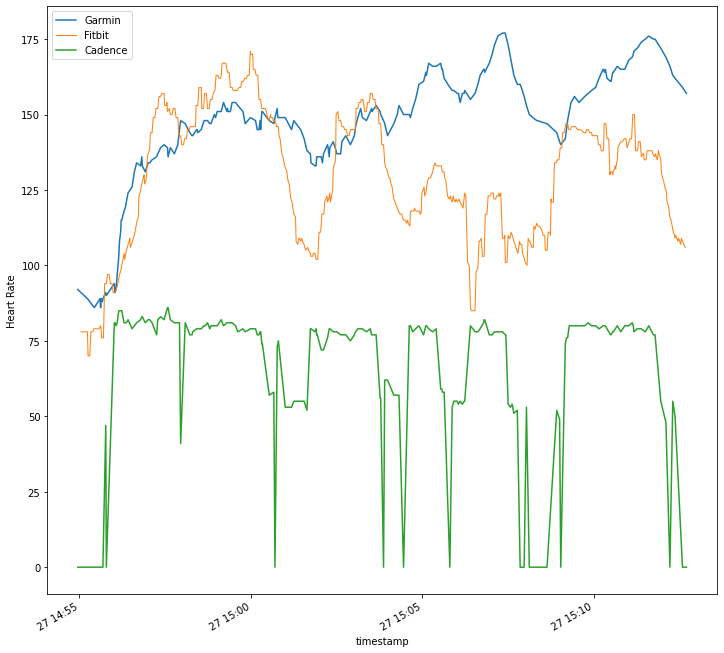

In [55]:
garmin_vs_fitbit(fit_run_df, garmin_run_df, gar_act = True)
garmin_run_df['cadence'].plot(label='Cadence')
plt.legend()

In [56]:
test = garmin_run_df[['hr', 'cadence']].merge(fit_run_df, left_index = True, \
                                              right_index = True)
test.head()
test.to_csv('test.csv')

In [57]:
print(len(test))

126


<AxesSubplot:>

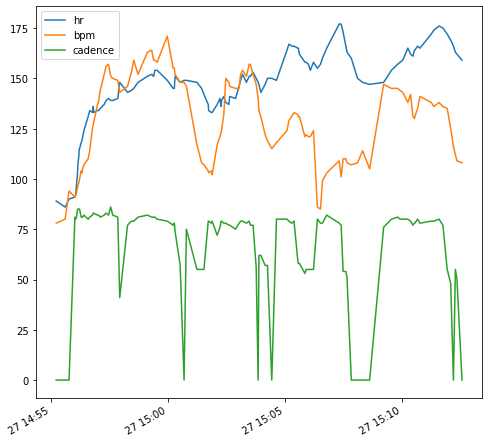

In [58]:
test[['hr', 'bpm', 'cadence']].plot()

<AxesSubplot:>

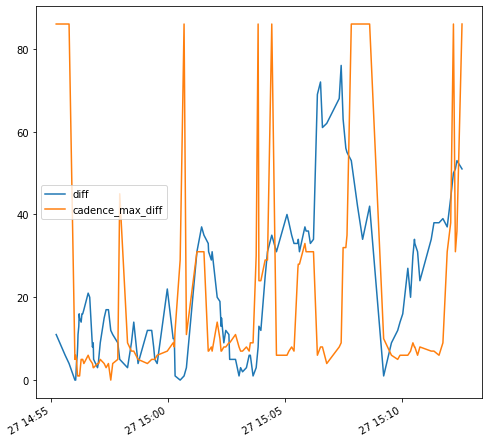

In [59]:
test['diff'] = abs(test['bpm'] - test['hr'])
test['cadence_diff'] = abs(test['cadence'] -test['cadence'].shift(1))
test['cadence_max_diff'] = max(test['cadence']) - test['cadence']
test['cadence_max_diff'] = test['cadence_max_diff']
test[['diff', 'cadence_max_diff']].plot()

<AxesSubplot:>

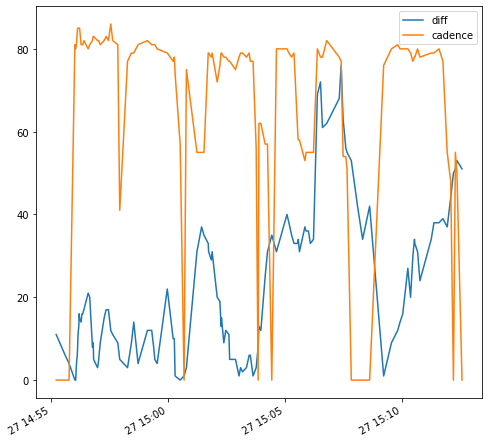

In [60]:
test[['diff', 'cadence']].plot()

In [61]:
garmin_run_df[['hr', 'cadence']].to_csv('garmin_test.csv')
fit_run_df.to_csv('fitbit.csv')

In [62]:
def open_json(direct, table):
    con = sqlite3.connect(direct)
    return pd.read_sql_query(f"SELECT * FROM {table}", con)

In [63]:
def cadence_plot(idx, garmin, fitbit, inFunc = True, peak = True):
    tmp = open_json('./HealthData/DBs/garmin_activities.db', 'activities')
    tmp = tmp[tmp['activity_id'] == idx]
    start = pd.to_datetime(tmp['start_time'].values[0])
    end = pd.to_datetime(tmp['stop_time'].values[0])
    for attempt in range(2):
        fitbit_tmp = fitbit.copy()
        if start >= pd.to_datetime('2022-03-27 01:00:00'):
            start = start + pd.Timedelta(1, 'h')
            end = end + pd.Timedelta(1, 'h')
            fitbit_tmp.index = fitbit.index.shift(1, freq='H')
        fitbit_tmp = fitbit_tmp[(fitbit_tmp.index >= start) &
                        (fitbit_tmp.index <= end)]
        if len(fitbit_tmp) == 0 and attempt == 0:
            print("Fitbit data for activity ", idx, "not found!")
            print("Trying to fetch data from Fitbit folder under Fitness folder directory...")
            %run fitbit_generate_hr.ipynb
            fitbit = pd.read_csv('./Fitbit/ShiYangLee/Physical Activity/heart_rate_full.csv')
            fitbit = fitbit_dataprep(fitbit)
            fitbit = fitbit.sort_index()
            continue
        if len(fitbit_tmp) == 0 and attempt == 1:
            raise ValueError("Fitbit data missing! Update Fitbit data manually by"
                             " replacing data export under Fitness directory and "
                             "generate complete hr data by running fitbit_generate_hr.ipynb")
        else:
            break
    fitbit_tmp = fitbit_tmp.resample('5s').mean()
    fitbit_tmp = fitbit_tmp.interpolate()
    garmin_tmp = garmin[garmin['activity_id'] == idx]
    garmin_tmp = garmin_tmp.set_index('timestamp')
    garmin_tmp.index = pd.to_datetime(garmin_tmp.index)
    garmin_tmp.index = garmin_tmp.index.map(lambda x : x + pd.Timedelta(1, 'h') \
                                              if x >= pd.to_datetime('2022-03-27 01:00:00') \
                                              else x)
    garmin_tmp = garmin_tmp[['hr', 'cadence']]
    garmin_tmp = garmin_tmp.resample('5s').mean()
    garmin_tmp['cadence_diff'] = abs(garmin_tmp['cadence'] - garmin_tmp['cadence'].shift(1))
    garmin_tmp['cadence_max_diff'] = max(garmin_tmp['cadence']) - garmin_tmp['cadence']
    garmin_tmp = garmin_tmp.interpolate()
    merged_df = garmin_tmp.merge(fitbit_tmp, left_index = True, \
                                              right_index = True)
    merged_df['diff'] = abs(merged_df['bpm'] - merged_df['hr'])
    # merged_df['cadence_diff'] = abs(merged_df['cadence'] -merged_df['cadence'].shift(1))
    # merged_df['cadence_max_diff'] = max(merged_df['cadence']) - merged_df['cadence']
    # merged_df['cadence_max_diff'] = merged_df['cadence_max_diff']
    if inFunc == False:
        fig, axs = plt.subplots(2, 1)
        axs[0].plot(merged_df[['hr', 'bpm', 'cadence']])
        axs[1].plot(merged_df[['diff', 'cadence_max_diff']])
        if peak == True:
            def to_date(value):
                _start = merged_df.index[0]
                return pd.to_datetime(_start) + pd.to_timedelta(5*value, 's')
            peaks, properties = signal.find_peaks(merged_df['diff'], height=20,\
                                                  width = 0)
            axs[1].plot(merged_df['diff'].iloc[peaks], "x")
            for i in range(len(peaks)):
                cmap = plt.cm.Reds
                norm = matplotlib.colors.Normalize(vmin=-1, vmax=len(peaks)+5)
                axs[1].axvspan(date2num(to_date(properties['left_ips'][i])),\
                           date2num(to_date(properties['right_ips'][i])), \
                              color = 'yellow')
                               # ymin=0, ymax = 80)
                           # ymin=peaks[i]-properties['prominences'][i], \
                           # ymax=merged_df['diff'].iloc[peaks[i]])
        plt.show()
    return merged_df   

In [64]:
fit_raw_df = pd.read_csv('./Fitbit/ShiYangLee/Physical Activity/heart_rate_full.csv')
fit_raw_df = fitbit_dataprep(fit_raw_df)
fit_raw_df.head()

,bpm,confidence
dateTime,,
2022-02-26 22:11:46,73,3
2022-02-26 22:11:51,76,3
2022-02-26 22:11:56,76,2
2022-02-26 22:12:06,75,2
2022-02-26 22:12:21,74,3


In [65]:
fit_raw_df.index = pd.to_datetime(fit_raw_df.index)

In [66]:
def all_cadence_plot(activity = 'running', save = False, fig_size = (12,12), peak = True):
    def garmin_get_running_id():
        garmin_act = open_json('./HealthData/DBs/garmin_activities.db', 'activities')
        garmin_act = garmin_act[garmin_act['sport'] == activity]
        return garmin_act['activity_id'].to_list()
    run_ids = garmin_get_running_id()
    fig, axs = plt.subplots(len(run_ids), 2, figsize=fig_size)
    for i in range(len(run_ids)):
        df = cadence_plot(run_ids[i], garmin_act_rec, fit_raw_df)
        axs[i, 0].plot(df[['hr', 'bpm', 'cadence']], \
                       label=['Garmin_hr', 'Fitbit_hr', 'Cadence'])
        axs[i, 0].legend()
        axs[i, 1].plot(df[['diff', 'cadence_max_diff']], \
                      label=['hr_difference', 'cadence_drop'])
        if peak == True:
            def to_date(value):
                _start = df.index[0]
                return pd.to_datetime(_start) + pd.to_timedelta(5*value, 's')
            peaks, properties = signal.find_peaks(df['diff'], height=20,\
                                                  width = 0)
            axs[i, 1].plot(df['diff'].iloc[peaks], "x")
            for j in range(len(peaks)):
                cmap = plt.cm.Reds
                norm = matplotlib.colors.Normalize(vmin=-1, vmax=len(peaks)+5)
                axs[i, 1].axvspan(date2num(to_date(properties['left_ips'][j])),\
                           date2num(to_date(properties['right_ips'][j])), \
                              color = 'yellow')
        axs[i, 1].legend()
    fig.supxlabel('Date Time')
    if save == True:
        plt.savefig('cadence_plot.png')
    plt.show()

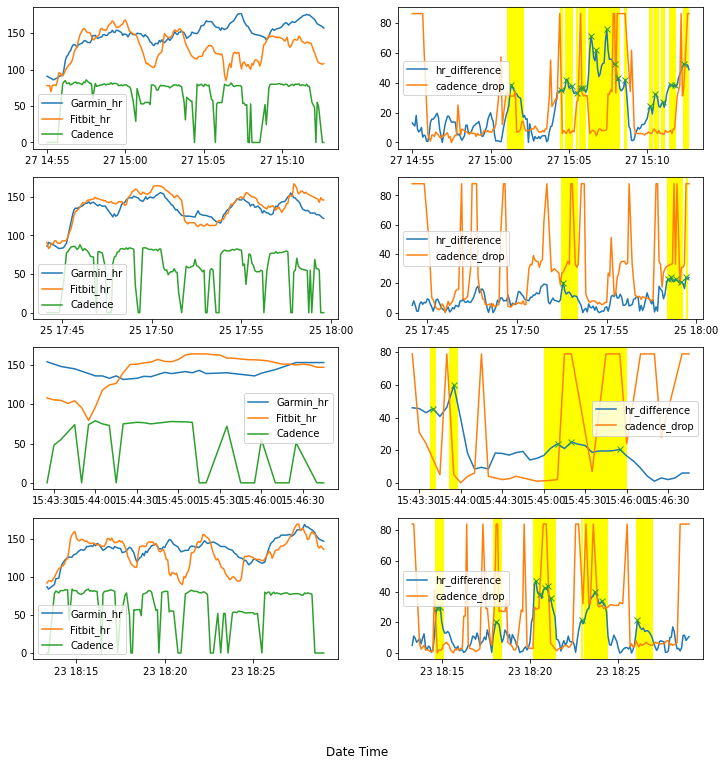

In [67]:
all_cadence_plot(save = True)

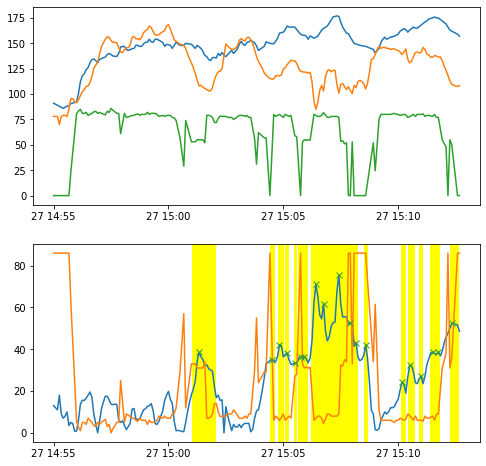

In [68]:
test_run = cadence_plot('8534680997', garmin_act_rec, fit_raw_df, inFunc = False)

In [69]:
test_run.index[0]

Timestamp('2022-03-27 14:55:00', freq='5S')

In [70]:
cadence_plot('8523132998', garmin_act_rec, fit_raw_df)

,hr,cadence,cadence_diff,cadence_max_diff,bpm,confidence,diff
2022-03-25 17:44:10,86.0,0.0,0.000000,88.0,91.0,0.0,5.0
2022-03-25 17:44:15,91.0,0.0,0.000000,88.0,83.0,2.0,8.0
2022-03-25 17:44:20,90.0,0.0,0.096154,88.0,85.0,2.0,5.0
2022-03-25 17:44:25,89.0,0.0,0.192308,88.0,90.0,2.0,1.0
2022-03-25 17:44:30,88.0,0.0,0.288462,88.0,89.0,2.0,1.0
...,...,...,...,...,...,...,...
2022-03-25 17:59:15,127.0,57.0,0.000000,31.0,147.0,2.0,20.0
2022-03-25 17:59:20,126.5,55.0,2.000000,33.0,143.0,2.0,16.5
2022-03-25 17:59:25,125.0,0.0,55.000000,88.0,149.0,2.0,24.0
2022-03-25 17:59:30,123.0,0.0,0.000000,88.0,146.0,2.0,23.0


In [71]:
cadence_plot('8693043387', garmin_act_rec, fit_raw_df)

,hr,cadence,cadence_diff,cadence_max_diff,bpm,confidence,diff
2022-04-23 18:13:20,87.000000,0.0,NaN,84.0,92.000000,1.0,5.000000
2022-04-23 18:13:25,84.000000,0.0,0.0,84.0,95.000000,2.0,11.000000
2022-04-23 18:13:30,85.500000,19.5,0.7,64.5,95.000000,2.0,9.500000
2022-04-23 18:13:35,87.000000,39.0,1.4,45.0,94.000000,2.0,7.000000
2022-04-23 18:13:40,88.500000,58.5,2.1,25.5,96.500000,2.0,8.000000
...,...,...,...,...,...,...,...
2022-04-23 18:28:40,151.750000,0.0,0.0,84.0,140.333333,2.0,11.416667
2022-04-23 18:28:45,149.500000,0.0,0.0,84.0,138.000000,2.0,11.500000
2022-04-23 18:28:50,148.666667,0.0,0.0,84.0,140.500000,2.0,8.166667
2022-04-23 18:28:55,147.833333,0.0,0.0,84.0,138.333333,2.0,9.500000


In [72]:
test = open_json('./HealthData/DBs/garmin_activities.db', 'activities')

In [73]:
test = test[test['sport'] == 'running']
test.head()

,start_time,stop_time,elapsed_time,moving_time,distance,cycles,avg_hr,max_hr,avg_rr,max_rr,calories,avg_cadence,max_cadence,avg_speed,max_speed,ascent,descent,max_temperature,min_temperature,avg_temperature,start_lat,start_long,stop_lat,stop_long,hr_zones_method,hrz_1_hr,hrz_2_hr,hrz_3_hr,hrz_4_hr,hrz_5_hr,hrz_1_time,hrz_2_time,hrz_3_time,hrz_4_time,hrz_5_time,activity_id,name,description,type,course_id,laps,sport,sub_sport,training_effect,anaerobic_training_effect
0,2022-03-27 13:54:57.000000,2022-03-27 14:12:48.000000,00:17:44.667000,00:17:44.667000,2.57899,1185.0,148,178,NaN,NaN,186,73.0,86.0,8.7192,12.5676,4.42,5.11,None,None,None,57.515198,-4.457854,57.515167,-4.458025,None,None,None,None,None,None,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,8534680997,Highlands Running,None,uncategorized,None,3,running,generic,None,None
1,2022-03-25 17:44:07.000000,2022-03-25 17:59:40.000000,00:15:27.403000,00:15:27.403000,2.00728,967.0,132,157,NaN,NaN,136,70.0,88.0,7.7904,13.1364,4.94,4.76,None,None,None,57.515087,-4.457877,57.515163,-4.457845,None,None,None,None,None,None,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,8523132998,Highlands Running,None,uncategorized,None,3,running,generic,None,None
14,2022-04-16 14:43:28.000000,2022-04-16 14:52:16.000000,00:03:20.360000,00:03:20.360000,0.37288,202.0,142,154,NaN,NaN,31,70.0,79.0,6.6996,10.6128,NaN,NaN,None,None,None,57.520046,-4.456715,57.517727,-4.459119,None,None,None,None,None,None,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,8649921197,Highlands Running,None,uncategorized,None,1,running,generic,None,None
21,2022-04-23 17:13:21.000000,2022-04-23 17:29:13.000000,00:15:41.738000,00:15:41.738000,2.15208,1039.0,137,169,NaN,NaN,126,72.0,86.0,8.2260,11.9232,2.08,3.31,None,None,None,57.515148,-4.457871,57.515171,-4.457905,None,None,None,None,None,None,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,8693043387,Highlands Running,None,uncategorized,None,3,running,generic,None,None


In [74]:
# dir_list = glob.glob('./Fitbit/ShiYangLee/Physical Activity/heart_rate-*.json')
# dfs = []
# for file in dir_list:
#     data = pd.read_json(file)
#     dfs.append(data)
# temp = pd.concat(dfs, ignore_index=True)

# temp

# data_split(temp)
# fitbit_raw_df = fitbit_dataprep(temp)

# fitbit_raw_df = fitbit_raw_df.sort_index()
# fitbit_raw_df

In [75]:
test_run

,hr,cadence,cadence_diff,cadence_max_diff,bpm,confidence,diff
2022-03-27 14:55:00,91.0,0.000000,NaN,86.000000,78.000000,2.0,13.000000
2022-03-27 14:55:05,90.0,0.000000,NaN,86.000000,78.000000,1.0,12.000000
2022-03-27 14:55:10,89.0,0.000000,NaN,86.000000,78.000000,0.0,11.000000
2022-03-27 14:55:15,88.0,0.000000,NaN,86.000000,70.000000,2.0,18.000000
2022-03-27 14:55:20,87.0,0.000000,NaN,86.000000,78.000000,2.0,9.000000
...,...,...,...,...,...,...,...
2022-03-27 15:12:20,162.0,50.000000,5.00,36.000000,109.666667,2.0,52.333333
2022-03-27 15:12:25,161.0,33.333333,3.75,52.666667,108.666667,2.0,52.333333
2022-03-27 15:12:30,160.0,16.666667,2.50,69.333333,108.000000,2.0,52.000000
2022-03-27 15:12:35,159.0,0.000000,1.25,86.000000,107.500000,2.0,51.500000


<AxesSubplot:>

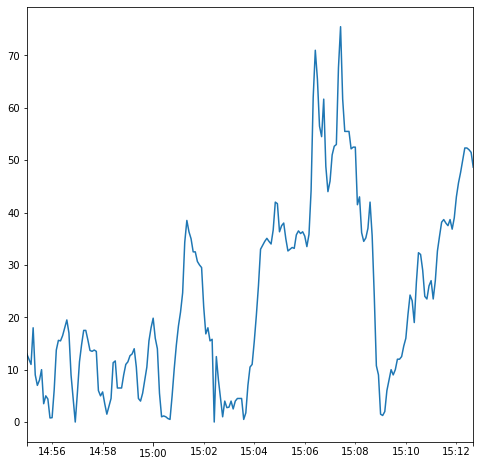

In [76]:
interpolate_test = test_run['diff'].interpolate()
interpolate_test = interpolate_test.resample('5S').mean()
interpolate_test = interpolate_test.interpolate()
interpolate_test.plot()

In [77]:
peak , properties = signal.find_peaks(test_run['diff'].values, prominence = 20, width = 1)
properties

{'prominences': array([38.5 , 27.  , 74.25]),
 'left_bases': array([23, 89, 89]),
 'right_bases': array([ 89, 143, 169]),
 'widths': array([12.18850806,  3.14122534, 24.37182927]),
 'width_heights': array([19.25 , 57.5  , 38.375]),
 'left_ips': array([ 72.34375   , 135.74766355, 134.305     ]),
 'right_ips': array([ 84.53225806, 138.88888889, 158.67682927])}

In [78]:
test_run['diff'].values

array([13.        , 12.        , 11.        , 18.        ,  9.        ,
        7.        ,  8.        , 10.        ,  3.5       ,  5.        ,
        4.38888889,  0.77777778,  0.83333333,  6.16666667, 13.75      ,
       15.6       , 15.5       , 16.5       , 18.        , 19.5       ,
       17.        ,  9.        ,  4.5       ,  0.        ,  5.5       ,
       11.5       , 14.75      , 17.5       , 17.5       , 15.66666667,
       13.66666667, 13.5       , 13.75      , 13.5       ,  6.        ,
        5.        ,  5.75      ,  3.5       ,  1.5       ,  3.        ,
        4.5       , 11.33333333, 11.66666667,  6.5       ,  6.5       ,
        6.5       ,  9.        , 11.        , 11.5       , 12.66666667,
       13.        , 14.        , 10.5       ,  4.5       ,  4.        ,
        5.5       ,  8.        , 10.5       , 15.5       , 18.        ,
       19.83333333, 16.        , 14.        ,  5.5       ,  1.        ,
        1.16666667,  1.        ,  0.66666667,  0.5       ,  5.  

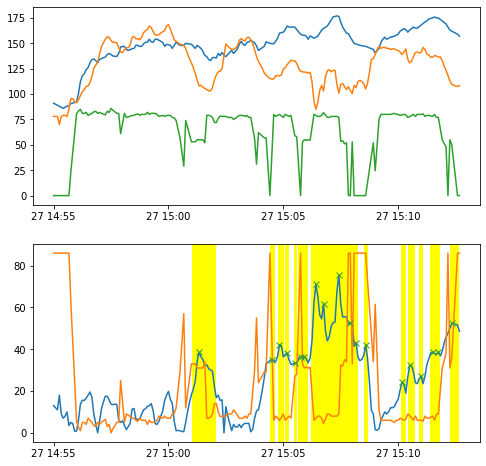

In [79]:
test_run = cadence_plot('8534680997', garmin_act_rec, fit_raw_df, peak = True, inFunc = False)

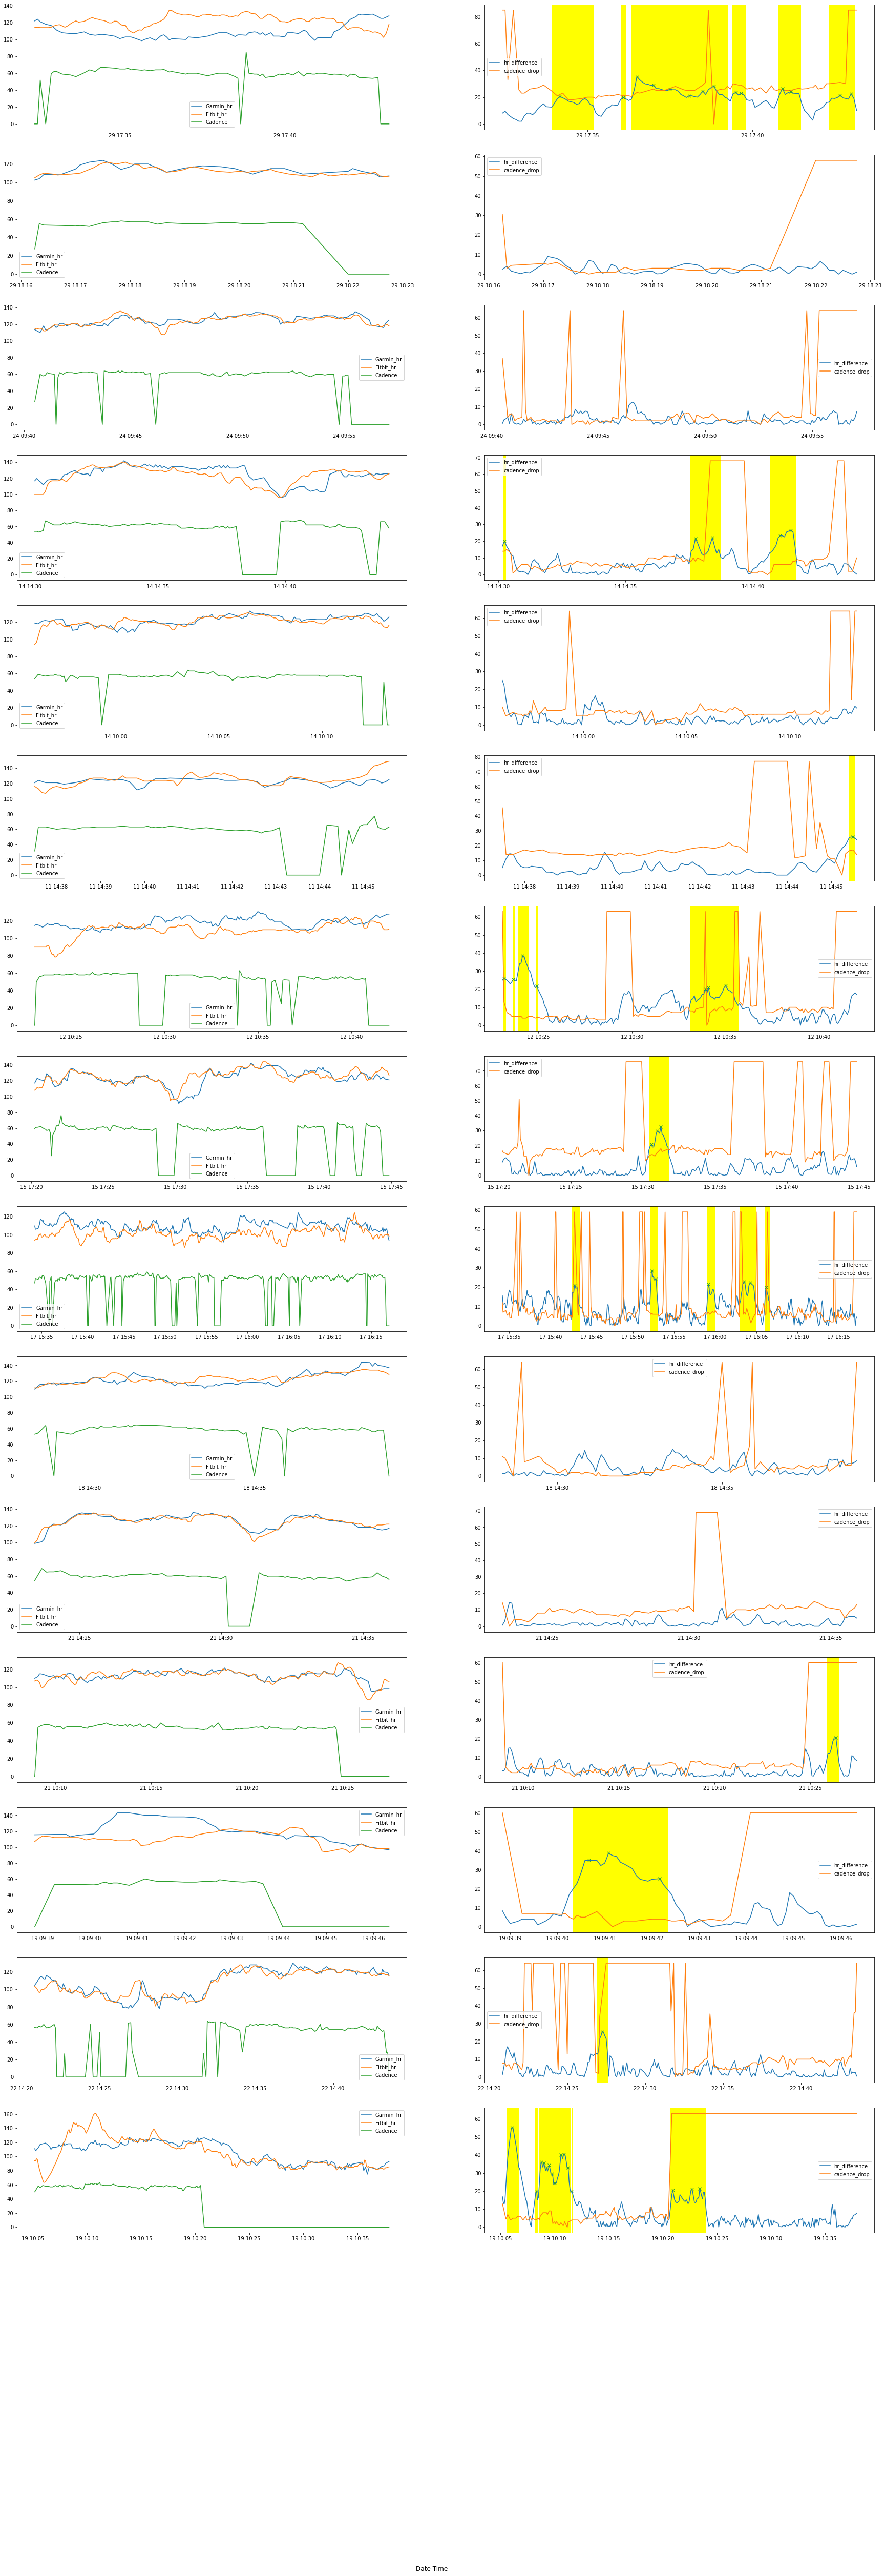

In [80]:
all_cadence_plot(activity = 'walking', fig_size=(30, 80))